# **Choosing Outperforming Stocks with Machine Learning**
### *By: Logan Chalifour*
### *Date: 12/21/2021*

### **Introduction**


This study will examine the trailing twelve-month returns (TTM) of the stocks in the S&P 500 to see if financial ratios can be leveraged to predict stocks that outperform the market using machine learning. Over the past 12 months, the S&P 500 has returned roughly 26% to investors, so that would be the return realized if passively invested in the index. However, as we know, many investors would much rather prefer excess returns by making savvy stock picks. In the past, these stock picks were made based on fundamental research to determine intrinsic value. Machine learning has brought about a new wave of investing where stock picks may be automated in order to outperform the market. In this study, I will see if several machine learning algorithms such as Random Forest, Gaussian Naive Bayes, and SVCs can predict stocks that outperform the market. The models will be fed several financial metrics in an attempt to predict outperforming stocks.

### **Imports**

We start by importing some packages that we'll need.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

### **Data Cleaning**

After importing the necessary packages, we set a random seed to ensure our work is replicable.

In [2]:
np.random.seed(21)

We start by grabbing some general data about the companies in the S&P 500 from Wikipedia.

In [3]:
tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
wiki_df = tables[0]
wiki_df.to_csv('S&P500-Info.csv')

wiki_df

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


Next, we manually grab some financial metrics pulled from FactSet that might be useful for predicting stock returns.

In [4]:
factset_df = pd.read_csv('S&P 500 FactSet Data.csv')

factset_df

,Symbol,Name,Price / Earnings,Price / Sales,Price / Book,PEG,EV / Sales,EV / EBITDA,EBIT Margin %,Piotroski F-Score,Mean Analyst Rating,TTM Total Return
0,MMM,3M Company,22.59,3.21,10.08,3.11,3.79,14.10,21.70,4.0,2.00,0.99
1,AOS,A. O. Smith Corporation,21.47,2.65,4.64,2.81,2.58,14.08,15.60,4.0,1.71,44.77
2,ABT,Abbott Laboratories,42.20,4.85,4.92,2.50,5.32,22.21,14.39,7.0,1.36,25.80
3,ABBV,"AbbVie, Inc.",16.75,3.95,NaN,0.82,4.77,9.93,41.83,6.0,1.32,31.27
4,ABMD,"ABIOMED, Inc.",32.76,7.91,6.13,3.75,7.40,23.07,29.57,4.0,1.67,7.78
...,...,...,...,...,...,...,...,...,...,...,...,...
495,YUM,"Yum! Brands, Inc.",24.37,5.63,NaN,3.20,7.51,20.08,33.82,7.0,1.73,21.86
496,ZBRA,Zebra Technologies Corporation Class A,25.64,3.14,7.50,NaN,3.45,17.73,15.35,6.0,1.58,53.02
497,ZBH,"Zimmer Biomet Holdings, Inc.",27.34,3.88,2.49,8.14,4.86,17.41,15.13,6.0,1.36,-21.22
498,ZION,"Zions Bancorporation, N.A.",12.38,2.98,1.26,NaN,4.18,NaN,NaN,NaN,1.75,48.29


In the dataframe above, `TTM Total Return` is our variable of interest or target variable. The other financial ratios are accurate as of a year ago, reflecting what information investors had at that point in time and will be used to predict the stock returns over the past year. Next, we combine the two dataframes by merging on the `symbol` column.

In [5]:
sp500_df = pd.merge(wiki_df, factset_df, how = "right", on=['Symbol', 'Symbol'])
sp500_df

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded,Name,Price / Earnings,Price / Sales,Price / Book,PEG,EV / Sales,EV / EBITDA,EBIT Margin %,Piotroski F-Score,Mean Analyst Rating,TTM Total Return
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740.0,1902,3M Company,22.59,3.21,10.08,3.11,3.79,14.10,21.70,4.0,2.00,0.99
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142.0,1916,A. O. Smith Corporation,21.47,2.65,4.64,2.81,2.58,14.08,15.60,4.0,1.71,44.77
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800.0,1888,Abbott Laboratories,42.20,4.85,4.92,2.50,5.32,22.21,14.39,7.0,1.36,25.80
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152.0,2013 (1888),"AbbVie, Inc.",16.75,3.95,NaN,0.82,4.77,9.93,41.83,6.0,1.32,31.27
4,ABMD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"ABIOMED, Inc.",32.76,7.91,6.13,3.75,7.40,23.07,29.57,4.0,1.67,7.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061.0,1997,"Yum! Brands, Inc.",24.37,5.63,NaN,3.20,7.51,20.08,33.82,7.0,1.73,21.86
496,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212.0,1969,Zebra Technologies Corporation Class A,25.64,3.14,7.50,NaN,3.45,17.73,15.35,6.0,1.58,53.02
497,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869.0,1927,"Zimmer Biomet Holdings, Inc.",27.34,3.88,2.49,8.14,4.86,17.41,15.13,6.0,1.36,-21.22
498,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380.0,1873,"Zions Bancorporation, N.A.",12.38,2.98,1.26,NaN,4.18,NaN,NaN,NaN,1.75,48.29


We start our EDA by looking at the unique GICS sectors to get an idea of what industries we are looking at.

In [6]:
sp500_df['GICS Sector'].unique()

array(['Industrials', 'Health Care', nan, 'Information Technology',
       'Communication Services', 'Utilities', 'Financials', 'Materials',
       'Real Estate', 'Consumer Staples', 'Consumer Discretionary',
       'Energy'], dtype=object)

We check the data types of each column to see if there is anything we need to change.

In [7]:
sp500_df.dtypes

Symbol                    object
Security                  object
GICS Sector               object
GICS Sub-Industry         object
Headquarters Location     object
Date added                object
CIK                      float64
Founded                   object
Name                      object
Price / Earnings         float64
Price / Sales            float64
Price / Book             float64
PEG                      float64
EV / Sales               float64
EV / EBITDA              float64
EBIT Margin %            float64
Piotroski F-Score        float64
Mean Analyst Rating      float64
TTM Total Return         float64
dtype: object

After checking the data types, everything looks okay, and we drop unneeded variables.

In [8]:
sp500_df = sp500_df.drop(columns = ['Date added', 'Headquarters Location', 'CIK', 'Name', 'Founded', 'Security', 'GICS Sector', 'GICS Sub-Industry'])

Next, we see if there are any null values.

In [9]:
sp500_df[sp500_df.isnull().any(axis=1)]

,Symbol,Price / Earnings,Price / Sales,Price / Book,PEG,EV / Sales,EV / EBITDA,EBIT Margin %,Piotroski F-Score,Mean Analyst Rating,TTM Total Return
3,ABBV,16.75,3.95,NaN,0.82,4.77,9.93,41.83,6.0,1.32,31.27
11,AFL,11.95,1.77,1.33,1.79,2.07,NaN,NaN,NaN,2.13,29.26
15,ALK,10.95,0.96,1.92,NaN,1.15,5.44,12.75,7.0,1.25,-2.01
17,ARE,51.80,11.87,2.20,11.31,17.29,24.70,33.22,NaN,1.17,25.80
21,ALL,8.02,0.84,1.51,1.07,1.05,NaN,NaN,NaN,1.47,7.36
...,...,...,...,...,...,...,...,...,...,...,...
490,WLTW,25.15,2.91,2.54,2.27,3.56,14.87,15.05,NaN,1.72,14.65
491,WYNN,120.80,2.25,8.55,NaN,3.46,14.16,14.83,4.0,1.53,-30.31
495,YUM,24.37,5.63,NaN,3.20,7.51,20.08,33.82,7.0,1.73,21.86
496,ZBRA,25.64,3.14,7.50,NaN,3.45,17.73,15.35,6.0,1.58,53.02


It appears that many of the financial metric columns have missing values so we fill them with the column mean.

In [10]:
sp500_df['Price / Earnings'].fillna(value=sp500_df['Price / Earnings'].mean(), inplace=True)
sp500_df['Price / Sales'].fillna(value=sp500_df['Price / Sales'].mean(), inplace=True)
sp500_df['Price / Book'].fillna(value=sp500_df['Price / Book'].mean(), inplace=True)
sp500_df['PEG'].fillna(value=sp500_df['PEG'].mean(), inplace=True)
sp500_df['EV / Sales'].fillna(value=sp500_df['EV / Sales'].mean(), inplace=True)
sp500_df['EV / EBITDA'].fillna(value=sp500_df['EV / EBITDA'].mean(), inplace=True)
sp500_df['EBIT Margin %'].fillna(value=sp500_df['EBIT Margin %'].mean(), inplace=True)
sp500_df['Piotroski F-Score'].fillna(value=sp500_df['Piotroski F-Score'].mean(), inplace=True)
sp500_df['Mean Analyst Rating'].fillna(value=sp500_df['Mean Analyst Rating'].mean(), inplace=True)
sp500_df['TTM Total Return'].fillna(value=sp500_df['TTM Total Return'].mean(), inplace=True)

We check for null values again to make sure we correctly filled the missing values.

In [11]:
#sp500_df[sp500_df.isnull().any(axis=1)]
#sp500_df = sp500_df.dropna()
sp500_df

,Symbol,Price / Earnings,Price / Sales,Price / Book,PEG,EV / Sales,EV / EBITDA,EBIT Margin %,Piotroski F-Score,Mean Analyst Rating,TTM Total Return
0,MMM,22.59,3.21,10.080000,3.110000,3.79,14.100000,21.700000,4.000000,2.00,0.99
1,AOS,21.47,2.65,4.640000,2.810000,2.58,14.080000,15.600000,4.000000,1.71,44.77
2,ABT,42.20,4.85,4.920000,2.500000,5.32,22.210000,14.390000,7.000000,1.36,25.80
3,ABBV,16.75,3.95,10.106255,0.820000,4.77,9.930000,41.830000,6.000000,1.32,31.27
4,ABMD,32.76,7.91,6.130000,3.750000,7.40,23.070000,29.570000,4.000000,1.67,7.78
...,...,...,...,...,...,...,...,...,...,...,...
495,YUM,24.37,5.63,10.106255,3.200000,7.51,20.080000,33.820000,7.000000,1.73,21.86
496,ZBRA,25.64,3.14,7.500000,10.272792,3.45,17.730000,15.350000,6.000000,1.58,53.02
497,ZBH,27.34,3.88,2.490000,8.140000,4.86,17.410000,15.130000,6.000000,1.36,-21.22
498,ZION,12.38,2.98,1.260000,10.272792,4.18,18.800716,16.509115,5.426065,1.75,48.29


We see our cleaned dataframe with 500 stocks, each with 9 features.

### **Exploratory Data Analysis**

To get a better understanding of the trailing twelve-month return for all the stocks, we take a look at a histogram showing the distribution.

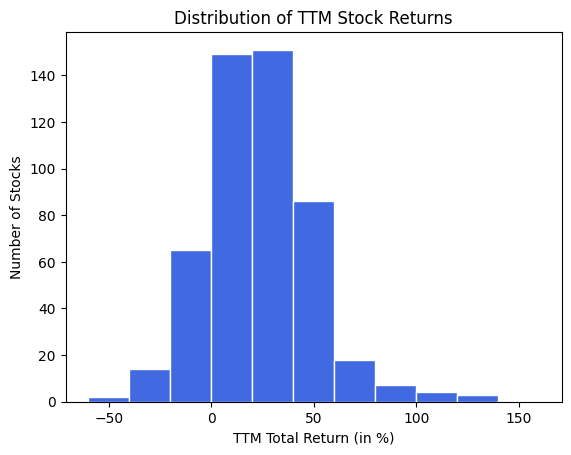

In [12]:
plt.hist(sp500_df['TTM Total Return'], bins = [-60, -40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 160], color = 'royalblue', edgecolor = 'white')
plt.title('Distribution of TTM Stock Returns')
plt.ylabel('Number of Stocks')
plt.xlabel('TTM Total Return (in %)');
plt.show()

As seen above, most stocks returned between 0 and 40% which makes sense since the S&P 500 return was roughly 26% on the year. Let's now take a look at a heatmap to see how these features are related to the target variable, `TTM Total Return`.

<AxesSubplot:>

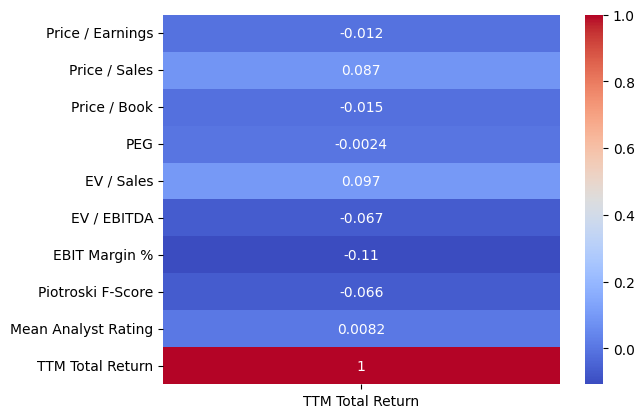

In [13]:
corrMatrix = sp500_df.corr()
sns.heatmap(corrMatrix[['TTM Total Return']], annot=True, cmap='coolwarm')

As seen above, most of the variables have a minimal correlation with our target variable, `TTM Total Return`. However, picking stocks in an efficient market is not so easy and even a slight edge given by these variables will be helpful to us.

### **Unsupervised Machine Learning**

Before diving into our supervised learning, we conduct some unsupervised learning to see what the machine can learn first without specifying a target variable. We start by preparing our dataframe for a hierarchical clustering dendrogram.

In [14]:
num_df = sp500_df.copy()
num_df = num_df.set_index('Symbol')
num_df

,Price / Earnings,Price / Sales,Price / Book,PEG,EV / Sales,EV / EBITDA,EBIT Margin %,Piotroski F-Score,Mean Analyst Rating,TTM Total Return
Symbol,,,,,,,,,,
MMM,22.59,3.21,10.080000,3.110000,3.79,14.100000,21.700000,4.000000,2.00,0.99
AOS,21.47,2.65,4.640000,2.810000,2.58,14.080000,15.600000,4.000000,1.71,44.77
ABT,42.20,4.85,4.920000,2.500000,5.32,22.210000,14.390000,7.000000,1.36,25.80
ABBV,16.75,3.95,10.106255,0.820000,4.77,9.930000,41.830000,6.000000,1.32,31.27
ABMD,32.76,7.91,6.130000,3.750000,7.40,23.070000,29.570000,4.000000,1.67,7.78
...,...,...,...,...,...,...,...,...,...,...
YUM,24.37,5.63,10.106255,3.200000,7.51,20.080000,33.820000,7.000000,1.73,21.86
ZBRA,25.64,3.14,7.500000,10.272792,3.45,17.730000,15.350000,6.000000,1.58,53.02
ZBH,27.34,3.88,2.490000,8.140000,4.86,17.410000,15.130000,6.000000,1.36,-21.22


With categorical features removed, we construct our dendrogram with the full pool of  500 stocks. Since we know 500 stocks overload our dendrogram, we take a look at a smaller portion of 20 stocks.

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [35.0, 35.0, 52.5, 52.5],
  [75.0, 75.0, 85.0, 85.0],
  [105.0, 105.0, 115.0, 115.0],
  [125.0, 125.0, 135.0, 135.0],
  [110.0, 110.0, 130.0, 130.0],
  [175.0, 175.0, 185.0, 185.0],
  [165.0, 165.0, 180.0, 180.0],
  [155.0, 155.0, 172.5, 172.5],
  [145.0, 145.0, 163.75, 163.75],
  [120.0, 120.0, 154.375, 154.375],
  [95.0, 95.0, 137.1875, 137.1875],
  [80.0, 80.0, 116.09375, 116.09375],
  [43.75, 43.75, 98.046875, 98.046875],
  [20.0, 20.0, 70.8984375, 70.8984375],
  [5.0, 5.0, 45.44921875, 45.44921875]],
 'dcoord': [[0.0, 27.12248443356283, 27.12248443356283, 0.0],
  [0.0, 13.936767354924081, 13.936767354924081, 0.0],
  [0.0, 22.94700935302444, 22.94700935302444, 13.936767354924081],
  [0.0, 27.09166420632991, 27.09166420632991, 22.94700935302444],
  [0.0, 30.305917992084268, 30.305917992084268, 0.0],
  [0.0, 8.295155212532194, 8.295155212532194, 0.0],
  [0.0, 8.438465500314619, 8.438465500

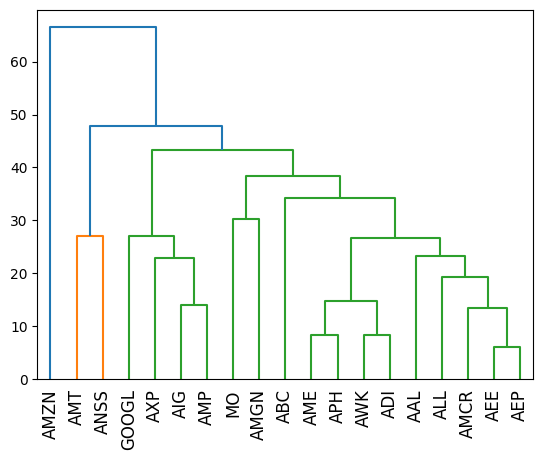

In [15]:
'''
Z = linkage(num_df, method='average')
dendrogram(Z, labels = num_df.index, leaf_rotation = 90)
'''

num_df = num_df[21:40]
Z = linkage(num_df, method='average')
dendrogram(Z, labels = num_df.index, leaf_rotation = 90)

We can clearly see three separate clusters that show how similar and/or different the stocks are from one another. If we look further at these clusters it becomes apparent that they have similar financial profiles due to their ratios.

### **Supervised Machine Learning**

Now we begin with our supervised learning to see if we can predict outperforming stocks over the past year with the financial metrics available to us a year ago. We start by creating a binary column that takes the vale of `1` if the `TTM Total Return` is greater than the S&P 500 return of 26%. Alternatively, the variable takes the value of `0` if the `TTM Total Return` is less than or equal to the S&P 500 return of 26%

In [16]:
#S&P 500 return is roughly 26% over TTM
sp500_df['Outperform'] = np.where(sp500_df['TTM Total Return'] > 26, 1, 0)

With that done, we check to see how many of the stocks over and underperformed.

In [17]:
sp500_df.groupby('Outperform').count()

,Symbol,Price / Earnings,Price / Sales,Price / Book,PEG,EV / Sales,EV / EBITDA,EBIT Margin %,Piotroski F-Score,Mean Analyst Rating,TTM Total Return
Outperform,,,,,,,,,,,
0,275,275,275,275,275,275,275,275,275,275,275
1,225,225,225,225,225,225,225,225,225,225,225


It appears that 225 stocks outperformed while 275 stocks underperformed. With that done, we separate our data into the feature set, `x_stocks`, and the target variable, `y_stocks`.

In [18]:
x_stocks = sp500_df.drop(['Symbol', 'TTM Total Return', 'Outperform'], axis=1)
y_stocks = sp500_df['Outperform']

We examine the shape of each dataframe to ensure it matches our expectations.

In [19]:
x_stocks.shape

(500, 9)

In [20]:
y_stocks.shape

(500,)

Everything looks all set, so we use an 80-20 split for our training and testing data.

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x_stocks, y_stocks, test_size = 0.2)

We train three separate models and examine their accuracies: Random Forest, Gaussian Naive Bayes, and a Support Vector Machine. 

In [22]:
m1 = RandomForestClassifier(n_estimators=100, random_state=0)
m1.fit(x_train, y_train)
y_m1 = m1.predict(x_test)

m2 = GaussianNB()
m2.fit(x_train, y_train)
y_m2 = m2.predict(x_test)

m3 = SVC(C=1E1)
m3.fit(x_train, y_train)
y_m3 = m3.predict(x_test)

print("Random Forest Accuracy:")
print(accuracy_score(y_test, y_m1))

print("Gaussian Naive Bayes Accuracy:")
print( accuracy_score(y_test, y_m2))

print("SVC Accuracy:")
print(accuracy_score(y_test, y_m3))

Random Forest Accuracy:
0.63
Gaussian Naive Bayes Accuracy:
0.51
SVC Accuracy:
0.53


As displayed in the accuracies above, the Random Forest model performed best with an accuracy of .63. Let's take a look at the feature importances to see which variables were most important in our model.

In [23]:
importances = m1.feature_importances_
feature_importances = pd.DataFrame({'feature':x_test.columns, 'importance':importances})
feature_importances = feature_importances.sort_values(by=['importance'], ascending=False)
feature_importances

,feature,importance
2,Price / Book,0.138590
1,Price / Sales,0.124373
5,EV / EBITDA,0.120044
0,Price / Earnings,0.117621
8,Mean Analyst Rating,0.115333
6,EBIT Margin %,0.114476
4,EV / Sales,0.109374
3,PEG,0.105224
7,Piotroski F-Score,0.054964


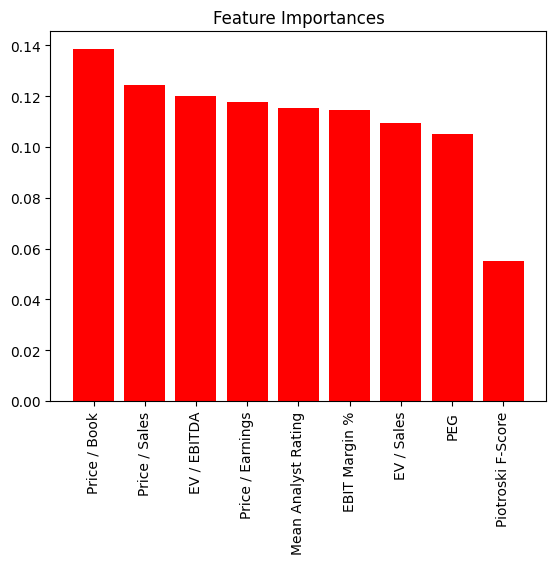

In [24]:
plt.figure()
plt.title("Feature Importances")
plt.bar(feature_importances['feature'], feature_importances['importance'],
       color="r", align="center")
plt.xticks(rotation = 90)

plt.show()

Above we see the most important variables in our model. We examine our Random Forest model further by constructing a confusion matrix and subsequent evaluation metrics.

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


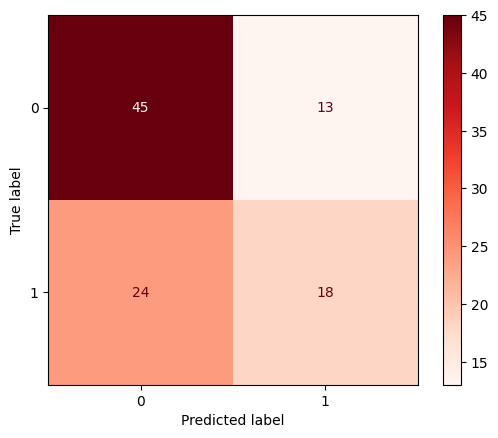

In [25]:
tn, fp, fn, tp = confusion_matrix(y_test, y_m1).ravel()

plot_confusion_matrix(m1, x_test, y_test, cmap='Reds')  
plt.show()

In [26]:
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precsion = tp / (tp + fp)
F1score = 2 * ((precsion * sensitivity) / (precsion + sensitivity))

print("Sensitivity:", sensitivity.round(2))
print("Specificity:", specificity.round(2))
print("Precision:", precsion.round(2))
print("F1 Score:", F1score.round(2))

Sensitivity: 0.43
Specificity: 0.78
Precision: 0.58
F1 Score: 0.49


It is evident that our model does a nice job predicting underperforming stocks successfully with a specificity of .78. Our model does a worse job predicting outperforming stocks with a sensitivity of .43. However, we are still happy with this overall because we would be able to avoid a lot of underperforming stocks if we deployed such a model while still hitting on roughly half of the overperforming stocks.

Lastly, let's take a look at the ROC to see how our model performs compared to the baseline model of guessing.

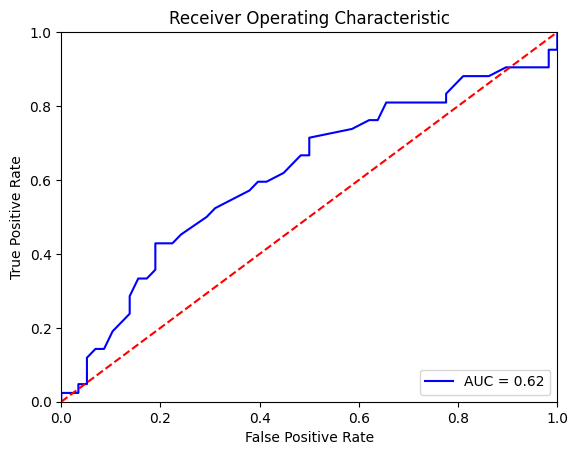

In [27]:
import sklearn.metrics as metrics

# calculate the fpr and tpr for all thresholds of the classification
probs = m1.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We are happy to see the true positive rate mostly above the null model at each respective false positive rate. While an AUC of .62 is traditionally not that helpful, in this case, it is because of the nature of the problem we are trying to solve. The truth is, stock picking is very difficult and even a slight edge due to a model can amount to outperformance over the S&P 500 benchmark.

### **Conclusion**

In summary, the Random Forest model is very useful in avoiding underperforming stocks while also hitting on nearly half of overperforming stocks. Given the difficult nature of stock picking, we are happy to see a .63 accuracy rate. While this may seem minuscule at first, such a model may lead to significant gains over the benchmark S&P 500 for investors depending on how much capital is deployed. Analyzing the model further, `Price / Book`, `Price / Sales`, `EV / EBITDA` were the most important features contributing to our model, while `Piotroski F-Score` was clearly the least important feature. Other models such as Gaussian Naive Bayes and SVCs also showed promise, but not as much as Random Forest. Further research in deep learning through the use of multilayer perceptrons may uncover even better-performing models.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b052e49a-74e4-4b34-a20a-eb7b8992f8b8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>